# **Upgrad DS-C57 - ML - Lead Scores Case Study**

### Problem Statement

X Education Company sells online courses and many professionals who are interested browse their and other website for courses. Leads are generated once they fill in the form with email id and/or mobile number or by past referrals.


The typical lead conversion rate is around 30% only. They need leads such that the conversion rate should increase, and the sales team will now be focusing more on communicating with the potential/hot leads rather than making calls to everyone.


### Objectives

- X Education Company want us to build a model to rate every lead by a score 0 to 100 based on the predictive conversion factors.

- The CEO of the company wants us to give such a model which can predict the lead conversion more than  80%.

- They also expect us to minimize the sales team manpower cost and to make calls only to the potential leads.


### Our Approach

  1. Read and Understand Data
  2. Run SweetViz automated EDA for quick analysis
  3. Data Cleaning
  4. Data Visualisation and Engineering
  5. Prepare data for Prediction
  6. Scaling
  7. Build Model to map Prediction to Probability Matrix
  8. RFE and VIF
  9. Model Evaluation
  10. Confusion Matrix
  11. Precision and Recall
  12. Conclusions

In [1]:
# Import required libraries
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")


**1. Read and Understand Data**

In [2]:
# Read data file
lead_df = pd.read_csv("Leads.csv")


In [3]:
# view first 5 rows of the data file
lead_df.head()


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
# view number of rows and columns in the data
lead_df.shape


(9240, 37)

In [5]:
# view basic information of the data file
lead_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

**2. Run SweetViz Automated EDA for quick analysis**

In [6]:
# Import SweetVix
!pip install sweetviz
import sweetviz as sv


In [7]:
# Create SweetViz Report and view it
sv_lead_report = sv.analyze(lead_df)
sv_lead_report.show_html("sv_lead_report1.html")


                                             |                                             | [  0%]   00:00 ->…

Report sv_lead_report1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##### Observations based on the sweetviz report

- There are total 37 features
- 31 categorical features
- 05 numerical features and
- 01 target variable

- 13 zero variance features (example "I agree to pay the amount through cheque", "Get updates on DM Content", .. etc )
- Many features have missing values
- Further some of the features have "Select" as default which is null


**3. Data Cleaning**

In [8]:
## Many columns has 'Select' (customer did not select any option and hence updating the same as 'null').
lead_df = lead_df.replace("Select", np.nan)


In [9]:
## Finding null percentage in each column
round(100*(lead_df.isnull().sum()/len(lead_df.index)), 2)


Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [10]:
## Drop columns where there are more than 30% Null
cols=lead_df.columns

for i in cols:
    if((100*(lead_df[i].isnull().sum()/len(lead_df.index))) >= 30):
        lead_df.drop(i, 1, inplace = True)


In [11]:
# view updated rows and columns
lead_df.shape


(9240, 27)

In [12]:
# view null value again
round(100*(lead_df.isnull().sum()/len(lead_df.index)), 2)


Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [13]:
# Drop Lead Number and Prospect ID since they have all unique values and they are not required for analysis
lead_df.drop(["Prospect ID", "Lead Number"], axis=1, inplace = True)


In [14]:
lead_df.head()


,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,...,No,No,No,No,No,No,No,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,...,No,No,No,No,No,No,No,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,...,No,No,No,No,No,No,No,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,...,No,No,No,No,No,No,No,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,...,No,No,No,No,No,No,No,No,No,Modified


In [15]:
lead_df["Lead Source"].value_counts(dropna=False)


Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [16]:
#replacing Nan Value with Google
lead_df["Lead Source"] = lead_df["Lead Source"].replace(np.nan,"Google")

#'Lead Source' is having same label name 'Google' but in different format i.e 'google', So converting google to Google
lead_df["Lead Source"] = lead_df["Lead Source"].replace("google", "Google")

# Replacing other sources of leads as others since there are small in number.
lead_df["Lead Source"] = lead_df["Lead Source"].replace(['bing','Click2call','Press_Release','Social Media',
                                                     'Live Chat','youtubechannel',
                                                     'testone','Pay per Click Ads','welearnblog_Home',
                                                     'WeLearn','blog','NC_EDM'],'Others')


In [17]:
lead_df["Country"].value_counts(dropna=False)


India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

In [18]:
## As most of the countries are not known and they are also large in number imputing
## the same null and unknown values as Not Available
lead_df["Country"]=lead_df["Country"].replace(np.nan,'Not Available')
lead_df["Country"]=lead_df["Country"].replace('unknown','Not Available')
lead_df["Country"]=lead_df["Country"].replace(['United Kingdom', 'Bahrain', 'Ghana',
        'Singapore','Qatar','Australia','Russia', 'Kuwait', 'Oman',
       'United Arab Emirates','Saudi Arabia', 'Belgium', 'France', 'Sri Lanka', 'China',
       'Canada', 'Netherlands', 'Sweden', 'Nigeria', 'Hong Kong',
       'Germany', 'Asia/Pacific Region', 'Uganda', 'Kenya', 'Italy',
       'South Africa', 'Tanzania', 'Malaysia', 'Liberia', 'Switzerland',
       'Denmark', 'Philippines', 'Bangladesh', 'Vietnam', 'Indonesia'],'Others')
lead_df["Country"].value_counts(dropna=False)


India            6492
Not Available    2466
Others            213
United States      69
Name: Country, dtype: int64

In [19]:
lead_df["What is your current occupation"].value_counts(dropna=False)


Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [20]:
## Imputing the current occupation with the mode value
lead_df["What is your current occupation"]=lead_df['What is your current occupation'].replace(np.nan, 'Unemployed')


In [21]:
lead_df["What matters most to you in choosing a course"].value_counts(dropna=False)


Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [22]:
## Imputing the reason to choose with the mode value
lead_df["What matters most to you in choosing a course"] = lead_df["What matters most to you in choosing a course"].replace(np.nan, "Better Career Prospects")


In [23]:
lead_df["What matters most to you in choosing a course"].value_counts(dropna=False)


Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [24]:
## Dropping all the rows as the overall percentage is very low.
lead_df.dropna(inplace=True)


In [25]:
round(100*(lead_df.isnull().sum()/len(lead_df.index)), 2)


Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                        0.0
Digital Advertisement                            0.0
Through Recommendations                       

In [26]:
lead_df['Last Notable Activity'].value_counts(dropna=False)


Modified                        3270
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: Last Notable Activity, dtype: int64

In [27]:
lead_df.shape


(9103, 25)

In [28]:
lead_df.describe()


,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9103.000000,9103.000000,9103.000000,9103.000000
mean,0.380204,3.445238,481.350104,2.362820
std,0.485464,4.854853,545.066142,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,9.000000,1.000000
50%,0.000000,3.000000,244.000000,2.000000
75%,1.000000,5.000000,919.500000,3.000000
max,1.000000,251.000000,2272.000000,55.000000


In [29]:
lead_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9103 entries, 0 to 9239
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9103 non-null   object 
 1   Lead Source                                    9103 non-null   object 
 2   Do Not Email                                   9103 non-null   object 
 3   Do Not Call                                    9103 non-null   object 
 4   Converted                                      9103 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9103 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9103 non-null   object 
 9   Country                                        9103 

In [30]:
lead_df["TotalVisits"] = lead_df["TotalVisits"].astype("int64")


In [31]:
lead_df.columns


Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

**4. Data Visualisation and Engineering**

In [32]:
## Run sweetviz again
sv_lead_report = sv.analyze(lead_df)
sv_lead_report.show_html("sv_lead_report2.html")

                                             |                                             | [  0%]   00:00 ->…

Report sv_lead_report2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [33]:
# Dropping features with zero variance
lead_df.drop(["Do Not Call" , "What matters most to you in choosing a course" , "Search" , "Magazine" ,  "Newspaper Article" ,
              "X Education Forums" , "Newspaper", "Digital Advertisement", "Through Recommendations",
              "Receive More Updates About Our Courses", "Update me on Supply Chain Content" ,
              "Get updates on DM Content" , "I agree to pay the amount through cheque"], axis=1, inplace = True)


In [34]:
lead_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9103 entries, 0 to 9239
Data columns (total 12 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9103 non-null   object 
 1   Lead Source                             9103 non-null   object 
 2   Do Not Email                            9103 non-null   object 
 3   Converted                               9103 non-null   int64  
 4   TotalVisits                             9103 non-null   int64  
 5   Total Time Spent on Website             9103 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9103 non-null   object 
 8   Country                                 9103 non-null   object 
 9   What is your current occupation         9103 non-null   object 
 10  A free copy of Mastering The Interview  9103 non-null   obje

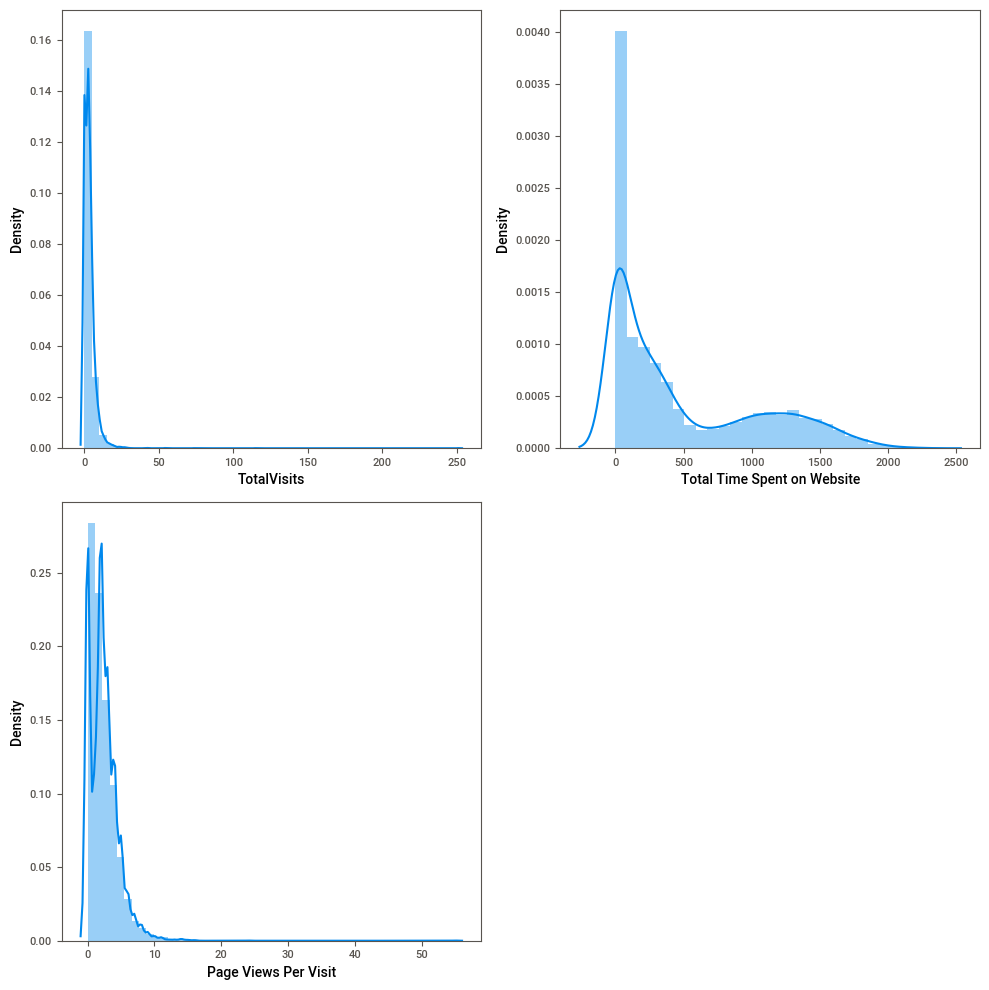

In [35]:
# Visualising Continuous variables
def plot(x, fig):
    plt.subplot(2,2,fig)
    sns.distplot(lead_df[x])
    plt.xlabel(x)


plt.figure(figsize=(10,10))

plot('TotalVisits',1)
plot('Total Time Spent on Website',2)
plot('Page Views Per Visit',3)

plt.tight_layout()


In [36]:
# Checking for Data Imbalance
round(((sum(lead_df['Converted'])/len(lead_df.index))*100),2)


38.02

##### It can be observed that there is an imbalance as only 38% leads are converted and 62% leads are not converted.

In [37]:
# View Correlation
lead_df.corr()


,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
Converted,1.000000,0.030395,0.354939,-0.003328
TotalVisits,0.030395,1.000000,0.221240,0.512125
Total Time Spent on Website,0.354939,0.221240,1.000000,0.320361
Page Views Per Visit,-0.003328,0.512125,0.320361,1.000000


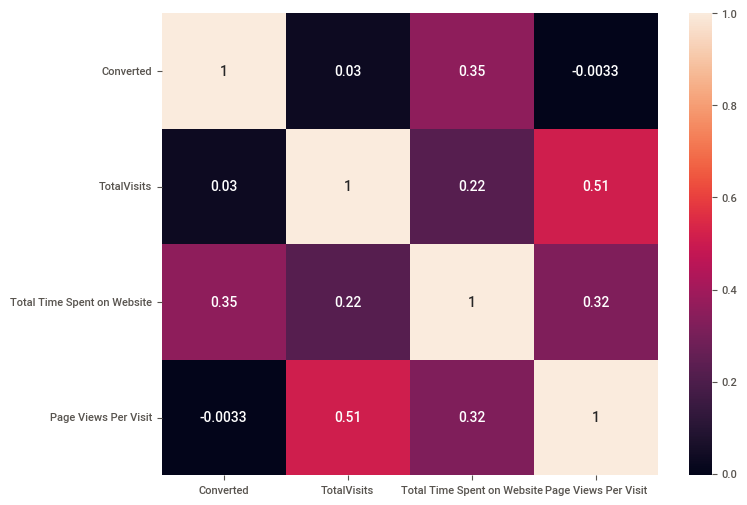

In [38]:
# Visualize
plt.figure(figsize=(8,6))
sns.heatmap(lead_df.corr(), annot=True)
plt.show()


### There is no high correlation between the dependent variable and the independent variables

In [39]:
# Categorical Columns
Cat_cols = lead_df.select_dtypes(include ="object").columns
Cat_cols

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Country', 'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

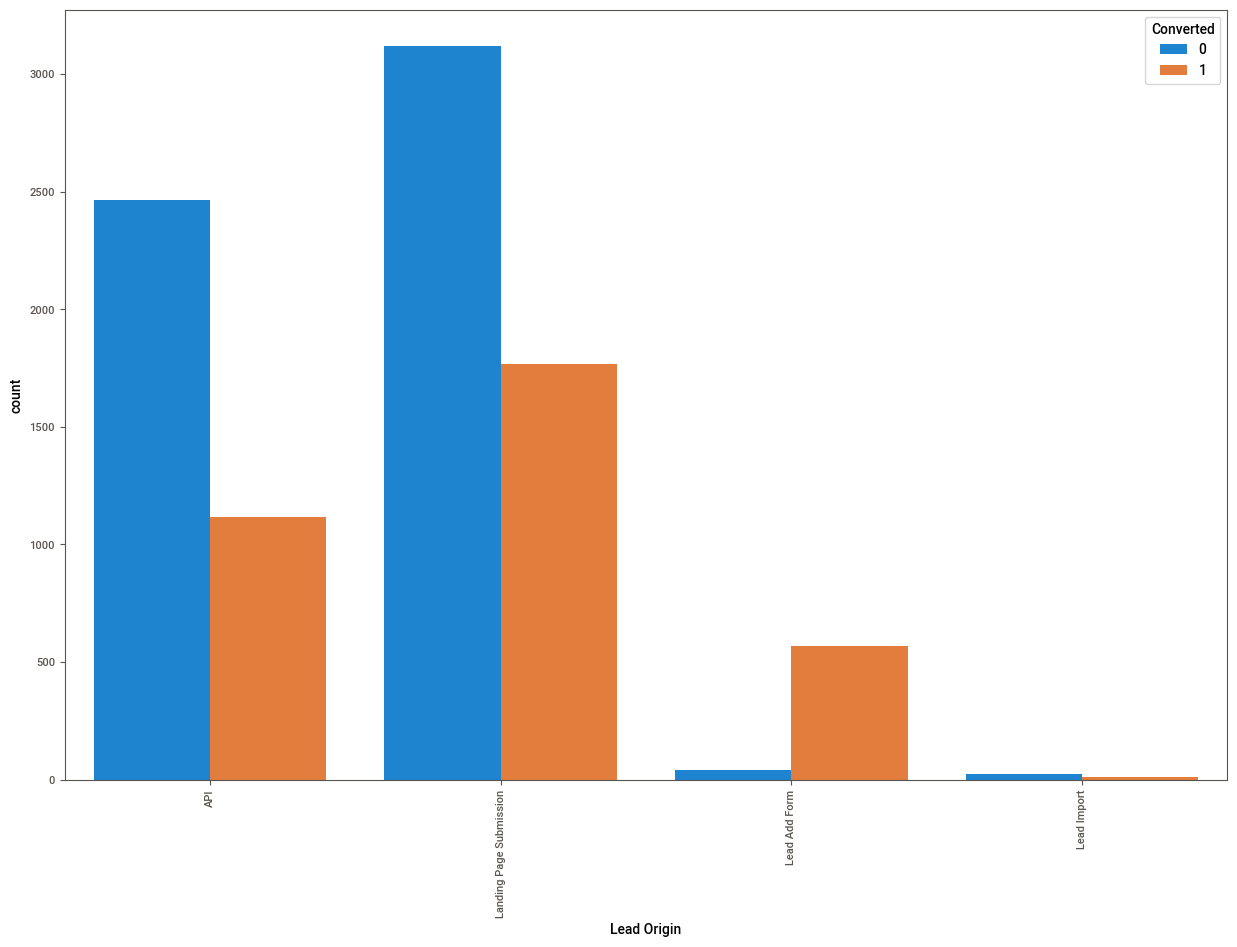

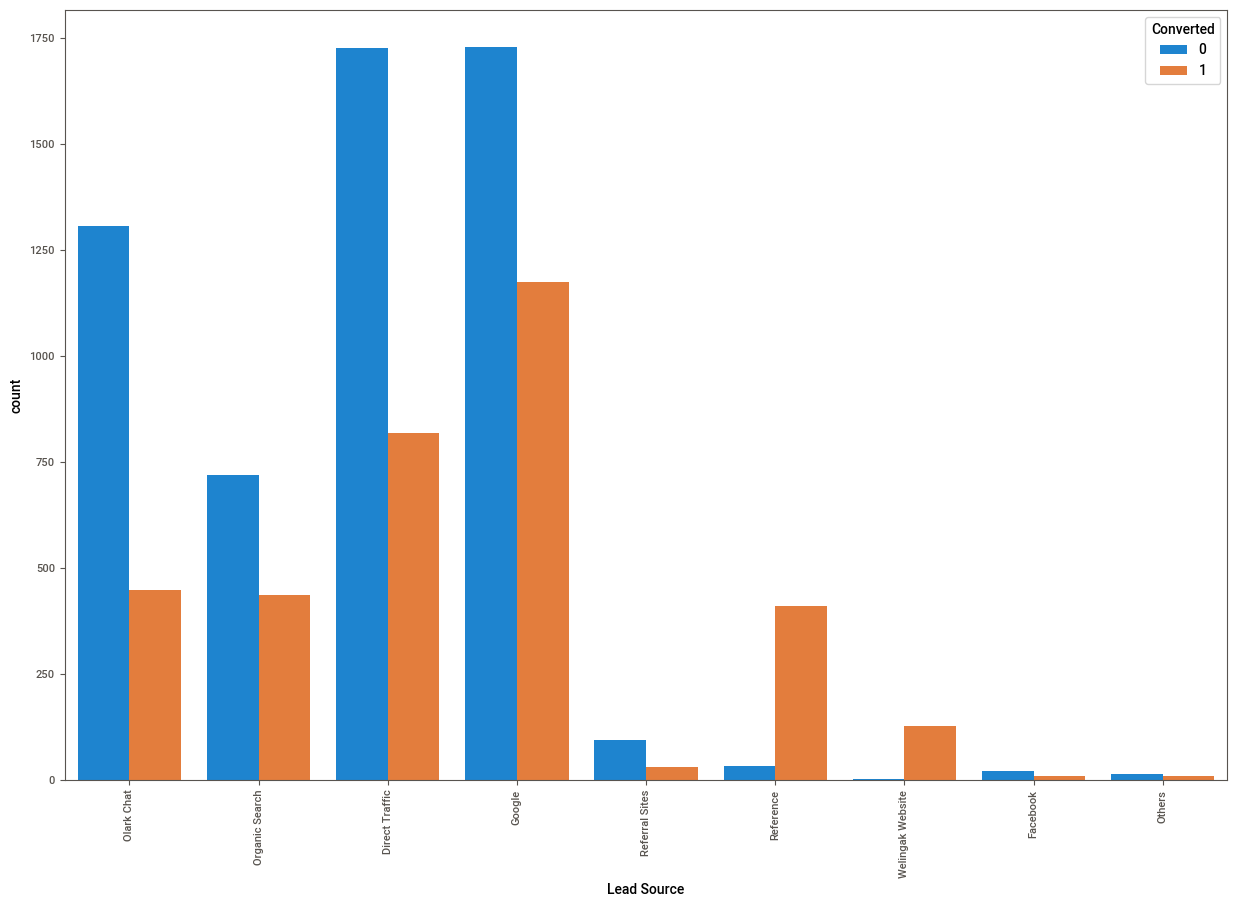

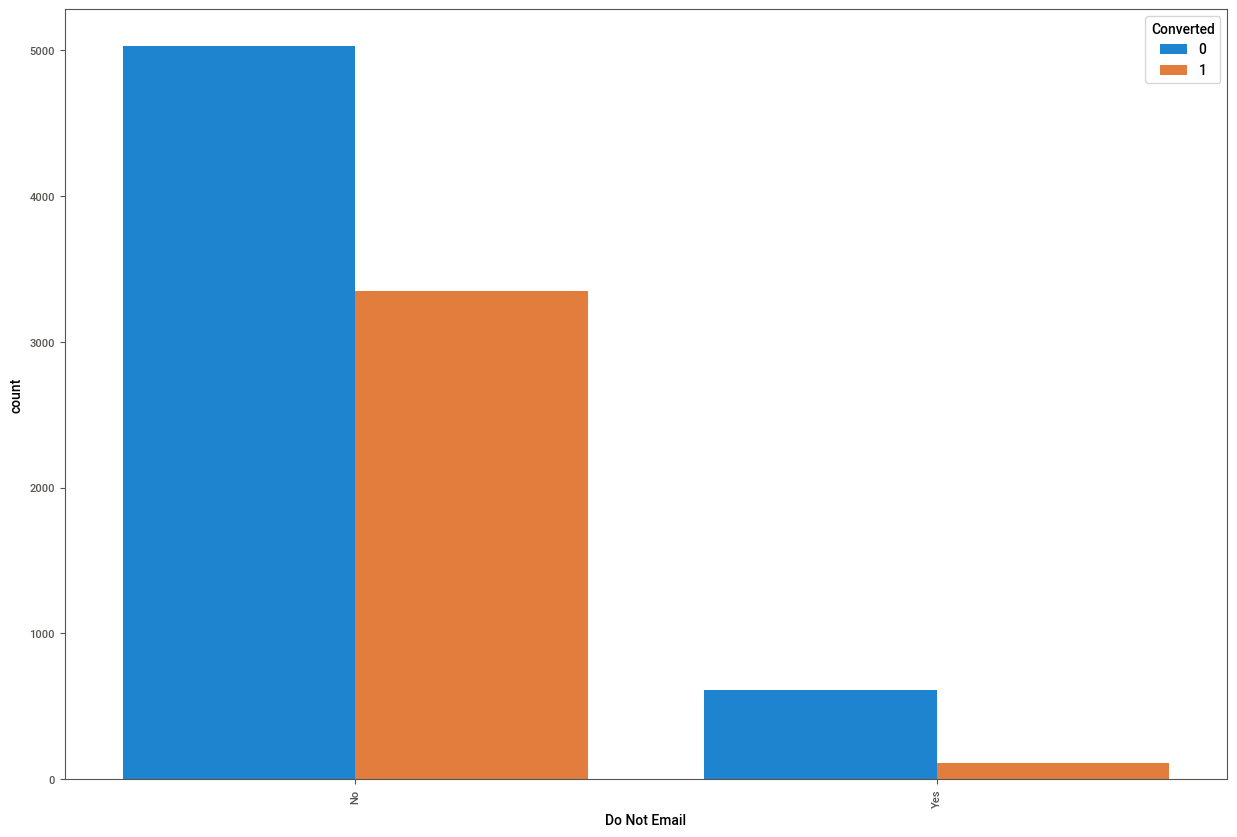

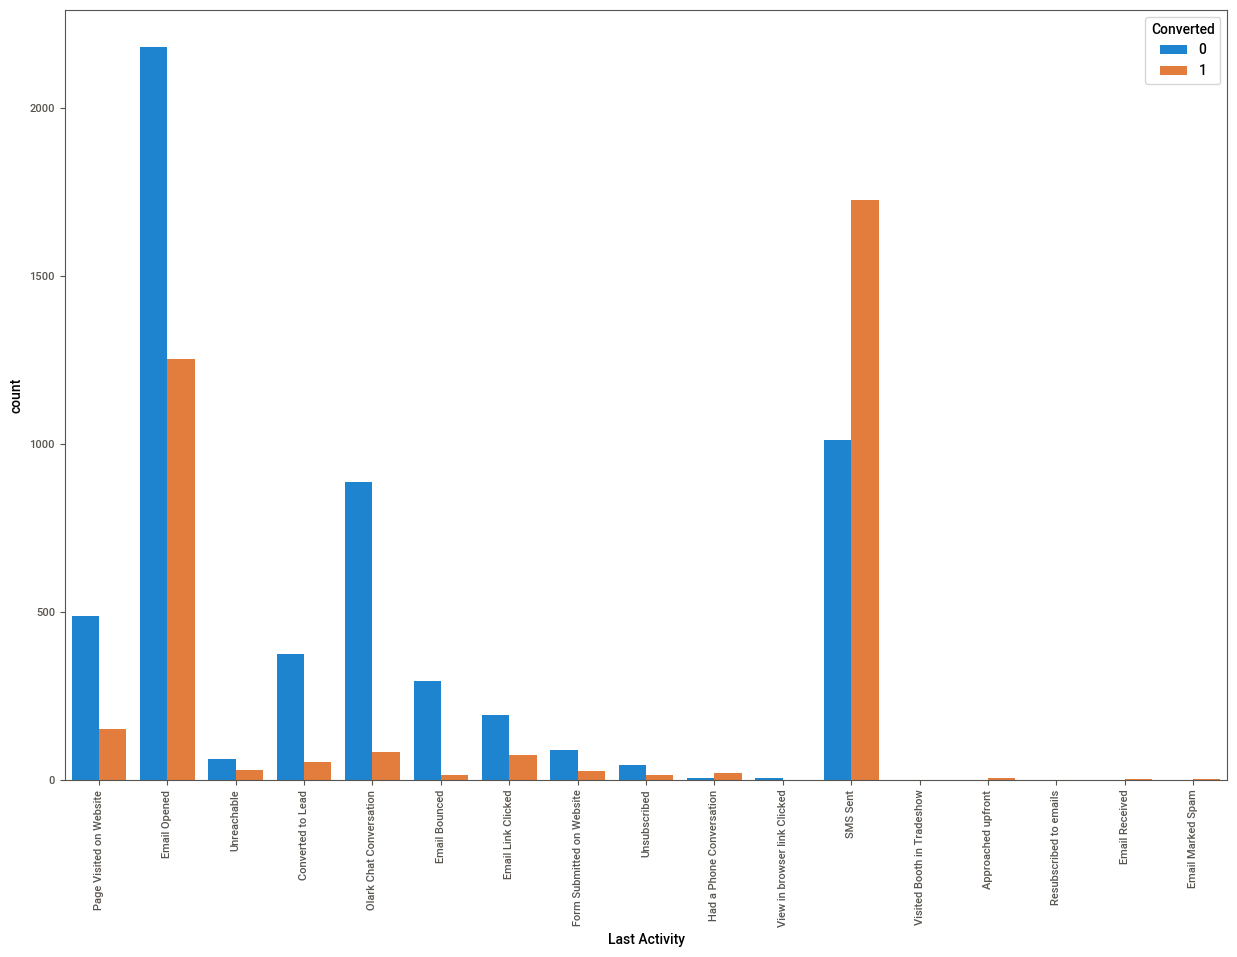

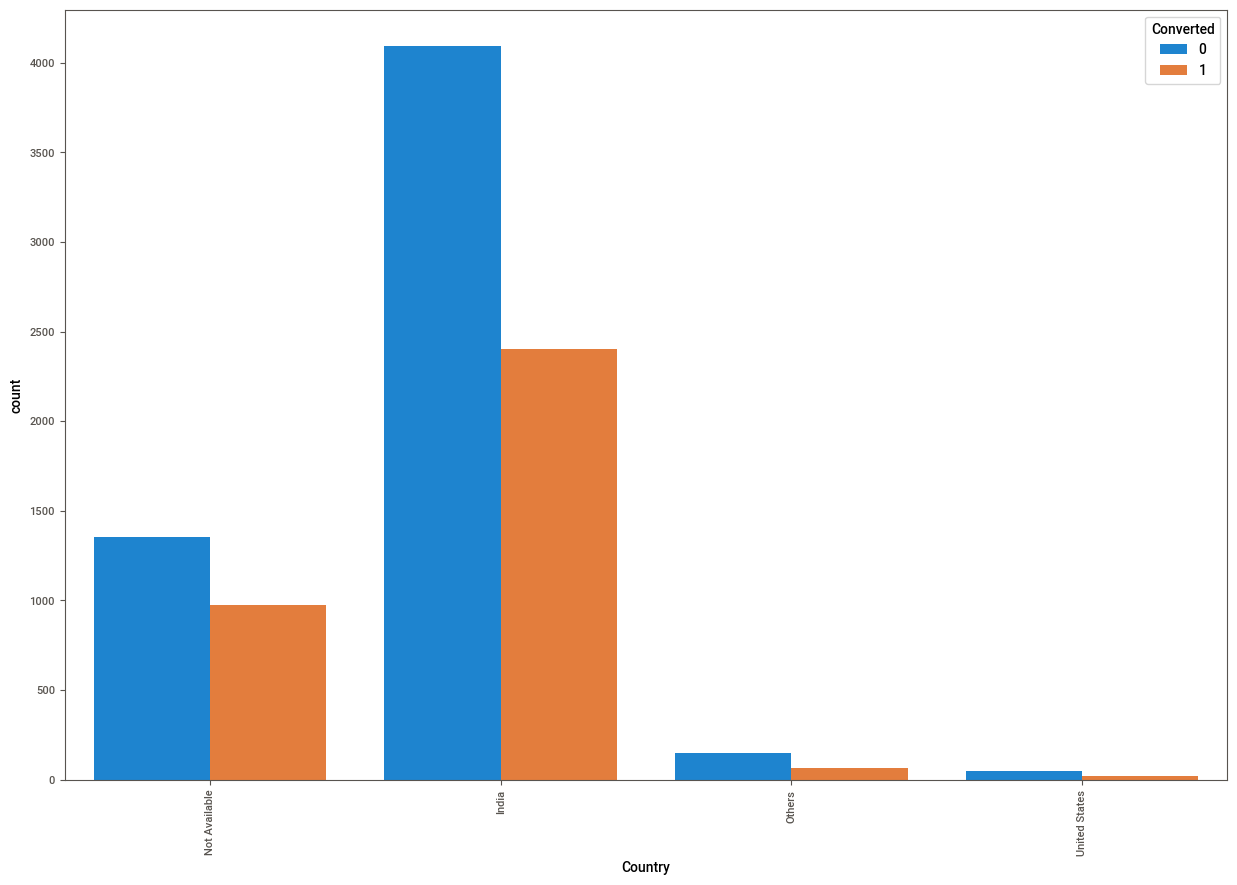

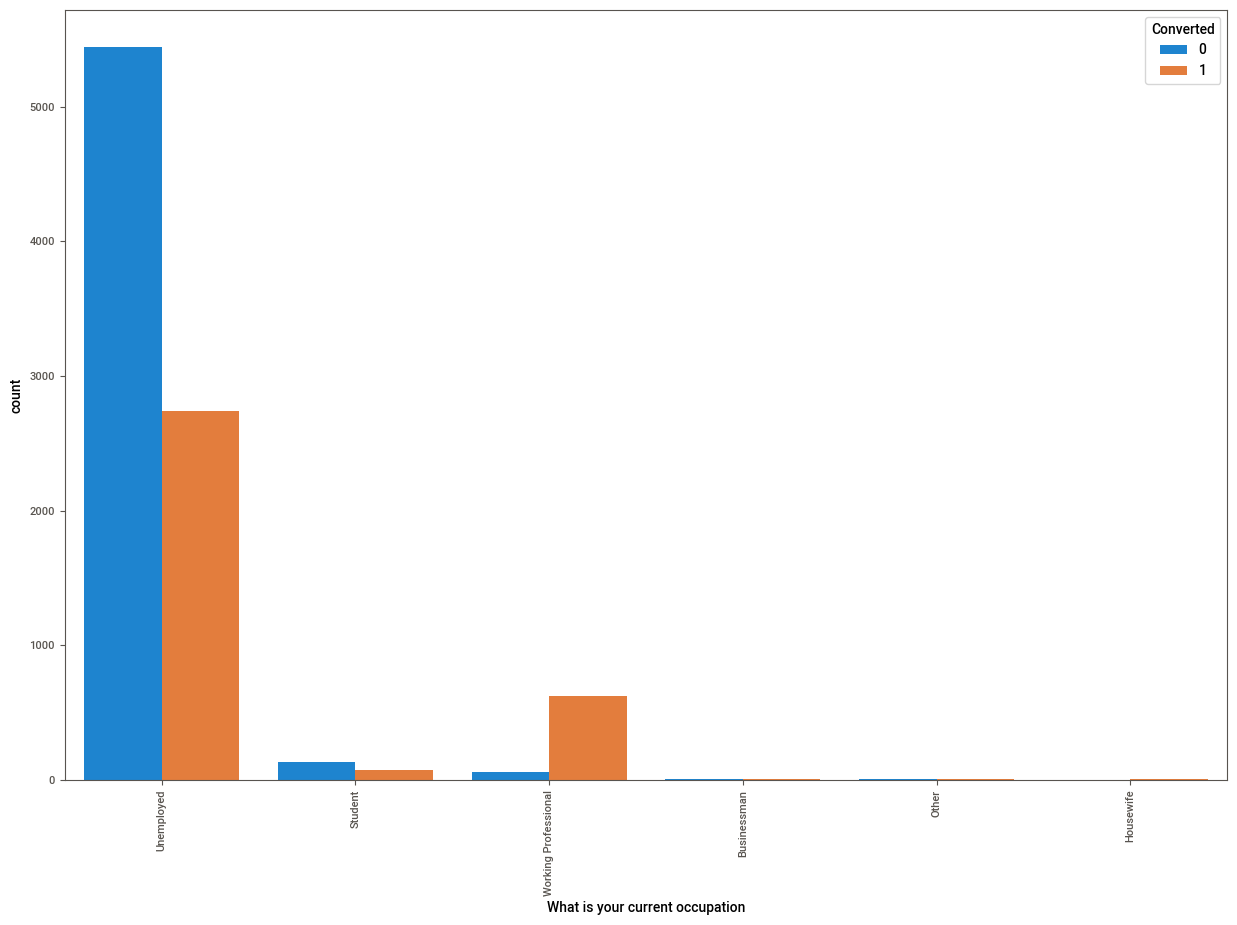

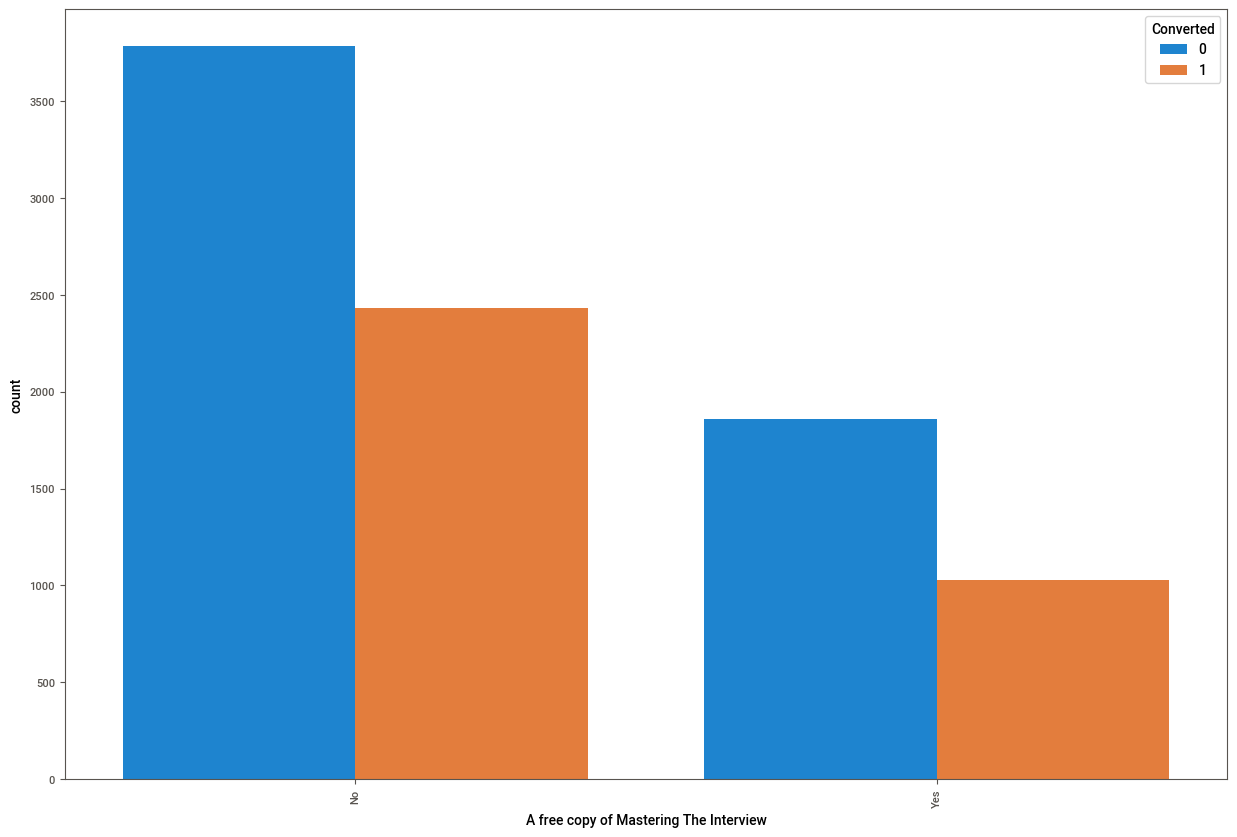

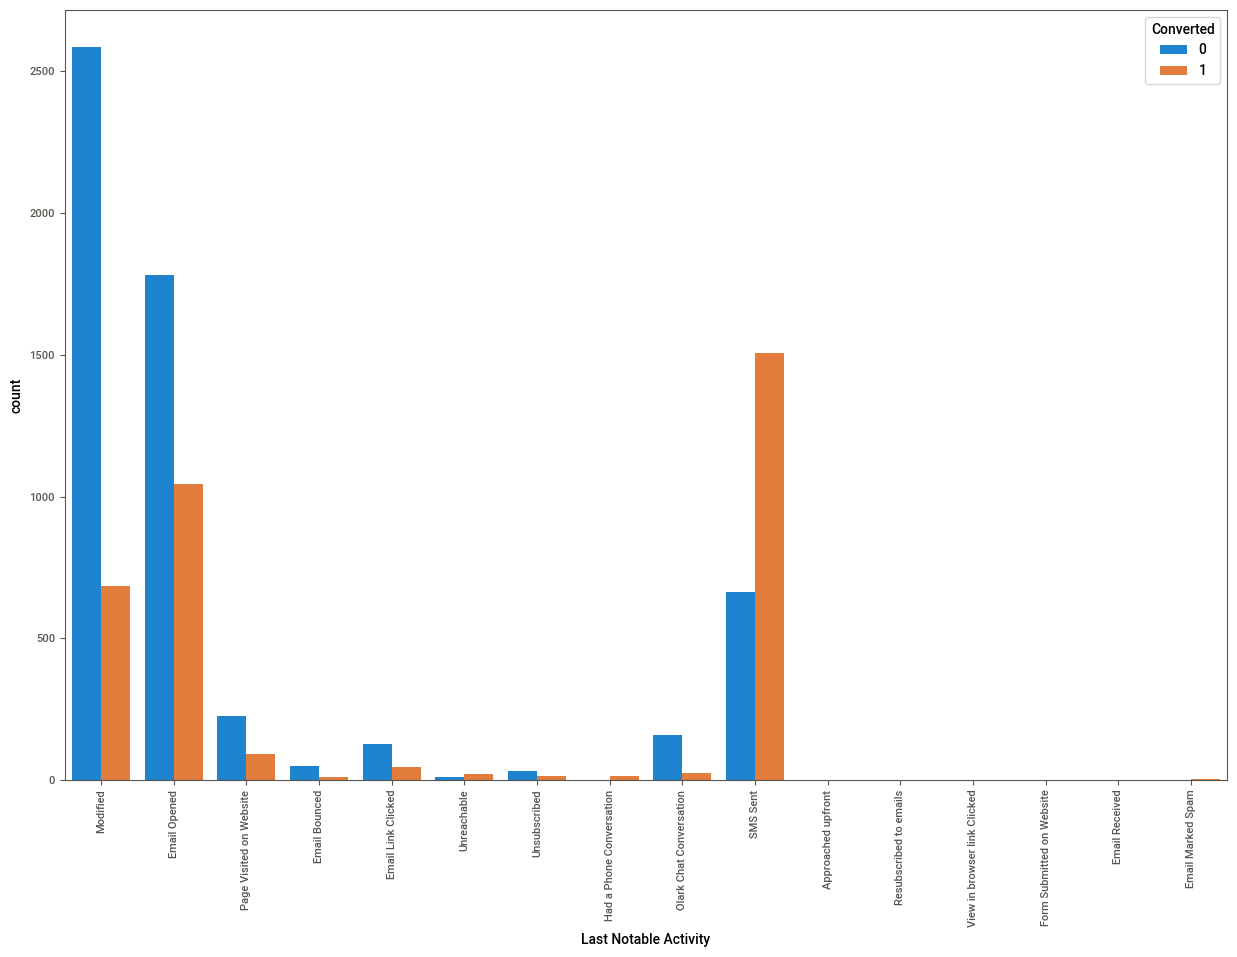

In [40]:
# Visualize
for i in Cat_cols:
    plt.figure(figsize=(15,10))
    sns.countplot(x=lead_df[i], hue='Converted', data = lead_df)
    plt.xticks(rotation = 90)
    plt.xlabel(i)
    plt.show()


In [41]:
# Drop Country as it has lot of imbalance
lead_df = lead_df.drop(["Country"] , axis = 1)


In [42]:
lead_df.shape


(9103, 11)

### Handling Outliers


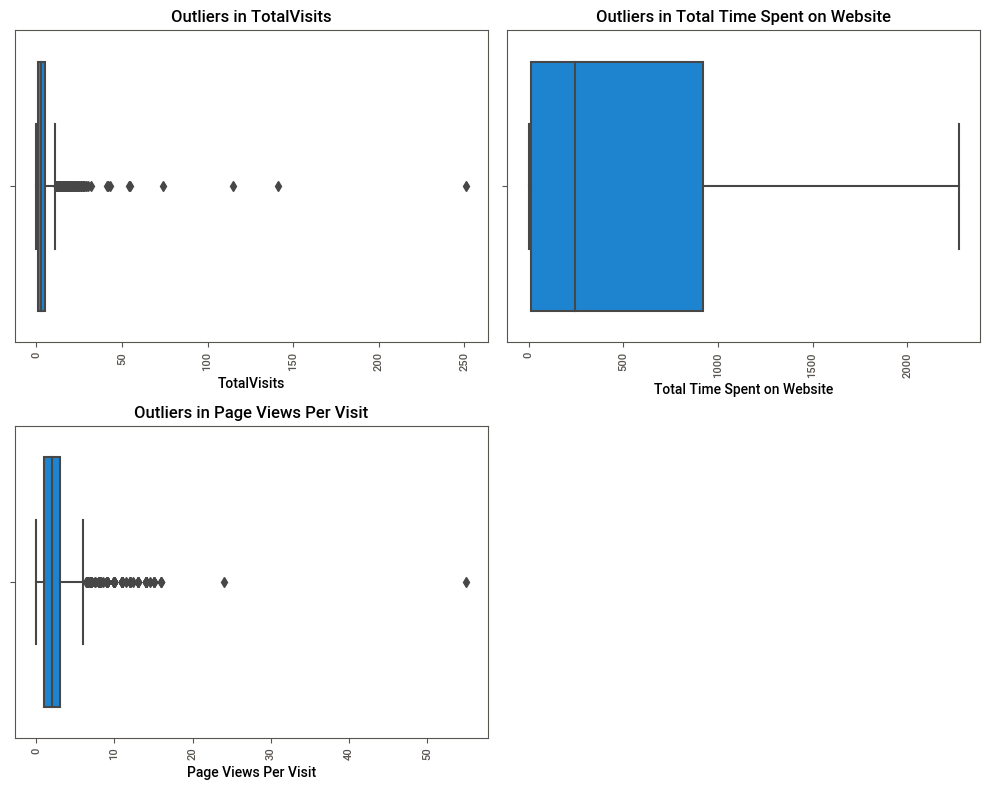

In [43]:
# Boxplot with Subplot
def boxplot(x,fig,):
    plt.subplot(2,2,fig)
    sns.boxplot(x = x, data = lead_df)
    plt.title('Outliers in'+' '+ x)
    plt.xlabel(x)
    plt.xticks(rotation = 90)

plt.figure(figsize =(10,8))

boxplot('TotalVisits',1)
boxplot('Total Time Spent on Website',2)
boxplot('Page Views Per Visit',3)

plt.tight_layout()


In [44]:
# We can observe outliers in Total visits and Page views per visit.
# Stastical method to check outliers
# Checking percentile values
lead_df[['Total Time Spent on Website','TotalVisits','Page Views Per Visit']].describe(
    percentiles=[0.01,0.05,.25, .5, .75, .90,0.95,0.99])


,Total Time Spent on Website,TotalVisits,Page Views Per Visit
count,9103.000000,9103.000000,9103.000000
mean,481.350104,3.445238,2.362820
std,545.066142,4.854853,2.161418
min,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000
25%,9.000000,1.000000,1.000000
50%,244.000000,3.000000,2.000000
75%,919.500000,5.000000,3.000000
90%,1372.000000,7.000000,5.000000


In [45]:
# Treating outliers using the IQR

Q1 = lead_df['TotalVisits'].quantile(0.01)
Q3 = lead_df['TotalVisits'].quantile(0.99)
lead_df = lead_df.loc[(lead_df['TotalVisits'] >= Q1) & (lead_df['TotalVisits'] <= Q3)]

Q1 = lead_df['Page Views Per Visit'].quantile(0.01)
Q3 = lead_df['Page Views Per Visit'].quantile(0.99)
lead_df=lead_df.loc[(lead_df['Page Views Per Visit'] >= Q1) & (lead_df['Page Views Per Visit'] <= Q3)]

Q1 = lead_df['Total Time Spent on Website'].quantile(0.01)
Q3 = lead_df['Total Time Spent on Website'].quantile(0.99)
lead_df=lead_df.loc[(lead_df['Total Time Spent on Website'] >= Q1) & (lead_df['Total Time Spent on Website'] <= Q3)]


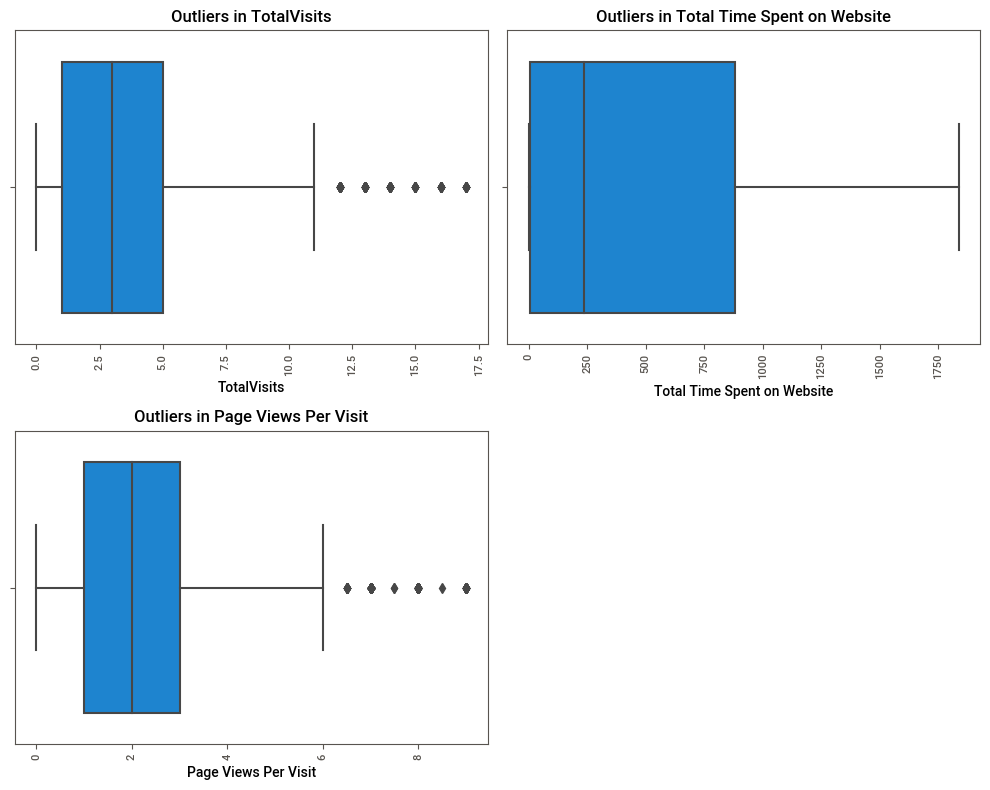

In [46]:
# visualize again
def boxplot(x,fig,):
    plt.subplot(2,2,fig)
    sns.boxplot(x = x, data = lead_df)
    plt.title('Outliers in'+' '+ x)
    plt.xlabel(x)
    plt.xticks(rotation = 90)
plt.figure(figsize =(10,8))

boxplot('TotalVisits',1)
boxplot('Total Time Spent on Website',2)
boxplot('Page Views Per Visit',3)

plt.tight_layout()


In [47]:
lead_df.shape


(8863, 11)

In [48]:
lead_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8863 entries, 0 to 9239
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             8863 non-null   object 
 1   Lead Source                             8863 non-null   object 
 2   Do Not Email                            8863 non-null   object 
 3   Converted                               8863 non-null   int64  
 4   TotalVisits                             8863 non-null   int64  
 5   Total Time Spent on Website             8863 non-null   int64  
 6   Page Views Per Visit                    8863 non-null   float64
 7   Last Activity                           8863 non-null   object 
 8   What is your current occupation         8863 non-null   object 
 9   A free copy of Mastering The Interview  8863 non-null   object 
 10  Last Notable Activity                   8863 non-null   obje

**Prepare data for Prediction**

In [49]:
# Dummy Variable Creation
temp= lead_df.loc[:, lead_df.dtypes==object]
temp.columns


Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [50]:
# Create dummies using 'get_dummies' command
dummy=pd.get_dummies(lead_df[['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity']], drop_first= True)


In [51]:
lead_df= pd.concat([lead_df, dummy], axis=1)


In [52]:
lead_df= lead_df.drop(temp, axis=1)


In [53]:
lead_df.head()


,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,5,674,2.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,1532,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,305,1.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,2,1428,1.0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [54]:
lead_df.shape


(8863, 53)

In [55]:
## Build Train and Test Model
from sklearn.model_selection import train_test_split


In [56]:
# All feature variables in 'X'
X=lead_df.drop(['Converted'], axis=1)
X.head()


,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0.0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,5,674,2.5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1532,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,305,1.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,1428,1.0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
# Target Variable in 'y'
y=lead_df['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [58]:
# Split the dataset into train 70% and test 30%
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3, random_state=100)


**6. Scaling, RFE, VIF**

In [59]:
## There are numeric variable present which has different scaler converting the same using min_max scaler
from sklearn.preprocessing import MinMaxScaler


In [60]:
# Scale the 3 numeric variables present in the dataset
scaler=MinMaxScaler()


In [61]:
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]=scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])


In [62]:
X_train.head()


,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
5428,0.000000,0.000000,0.000000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8583,0.294118,0.837235,0.277778,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4637,0.117647,0.037561,0.222222,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4468,0.176471,0.189984,0.333333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2058,0.411765,0.082199,0.155556,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
lead_df.corr()


,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Converted,1.000000,0.040540,0.352254,-0.009181,-0.043947,0.313135,-0.010512,-0.010512,0.032457,-0.124130,...,-0.008251,0.043259,-0.263031,-0.074276,-0.031569,0.013676,0.365858,0.038671,-0.016164,-0.008251
TotalVisits,0.040540,1.000000,0.353484,0.722372,0.435851,-0.269666,-0.058663,-0.056026,0.212006,-0.479852,...,-0.004135,0.027802,-0.152536,-0.055923,0.194882,-0.011464,0.015588,0.016159,0.004509,0.017854
Total Time Spent on Website,0.352254,0.353484,1.000000,0.352520,0.300475,-0.194491,-0.051845,-0.050435,0.218972,-0.381617,...,-0.003549,0.027637,-0.124363,-0.052033,0.035016,-0.009345,0.131148,0.012365,0.000587,-0.007548
Page Views Per Visit,-0.009181,0.722372,0.352520,1.000000,0.540321,-0.303403,-0.062515,-0.058481,0.248381,-0.553576,...,-0.001444,0.016727,-0.117257,-0.094028,0.028441,-0.012656,0.065567,0.025975,0.015839,0.002312
Lead Origin_Landing Page Submission,-0.043947,0.435851,0.300475,0.540321,1.000000,-0.288565,-0.063050,-0.059220,0.078270,-0.527682,...,0.009982,0.000567,-0.080019,-0.118493,0.036503,-0.011305,0.047996,0.000020,0.013046,-0.011305
Lead Origin_Lead Add Form,0.313135,-0.269666,-0.194491,-0.303403,-0.288565,1.000000,-0.016064,-0.016064,-0.159034,-0.132201,...,-0.002880,-0.010392,-0.074609,-0.026517,-0.014273,-0.002880,0.127427,0.006021,-0.006800,-0.002880
Lead Origin_Lead Import,-0.010512,-0.058663,-0.051845,-0.062515,-0.063050,-0.016064,1.000000,0.967629,-0.036510,-0.029376,...,-0.000629,-0.002271,-0.008738,-0.008554,-0.010838,-0.000629,-0.028629,-0.003566,-0.004232,-0.000629
Lead Source_Facebook,-0.010512,-0.056026,-0.050435,-0.058481,-0.059220,-0.016064,0.967629,1.000000,-0.040608,-0.029376,...,-0.000629,-0.002271,-0.008738,-0.008554,-0.010838,-0.000629,-0.024142,-0.003566,-0.004232,-0.000629
Lead Source_Google,0.032457,0.212006,0.218972,0.248381,0.078270,-0.159034,-0.036510,-0.040608,1.000000,-0.339862,...,-0.007281,0.030628,-0.008149,-0.033965,0.005826,-0.007281,0.004290,0.011179,0.005501,0.015498
Lead Source_Olark Chat,-0.124130,-0.479852,-0.381617,-0.553576,-0.527682,-0.132201,-0.029376,-0.029376,-0.339862,1.000000,...,-0.005267,-0.011596,0.101706,0.164924,-0.052268,0.021424,-0.100766,-0.010941,-0.011488,-0.005267


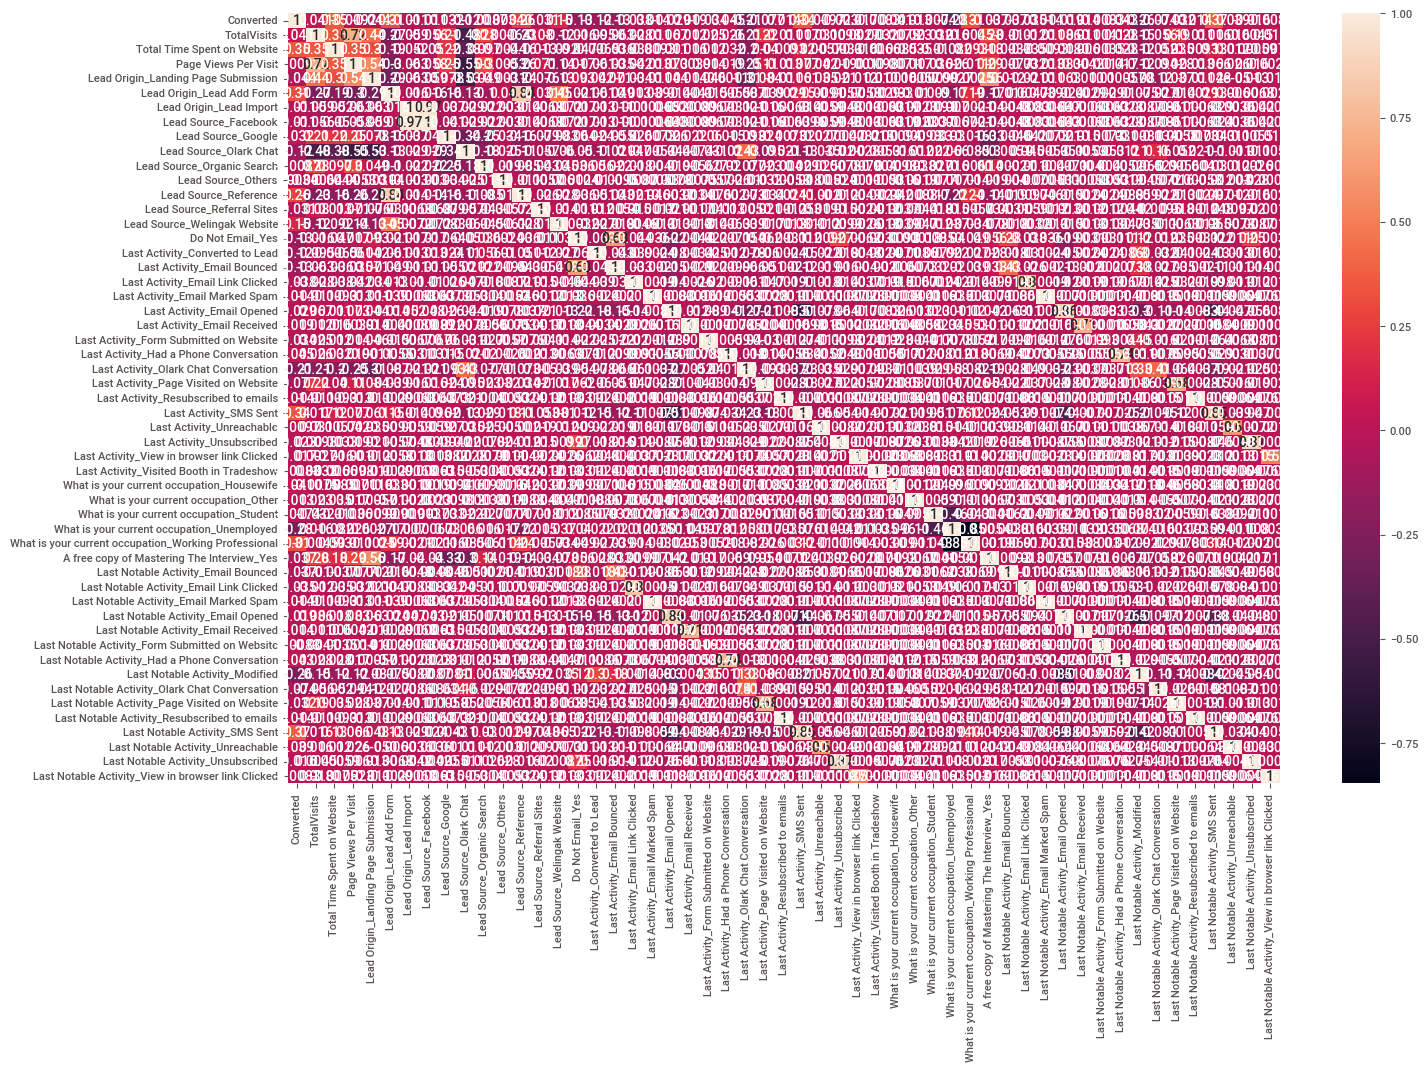

In [64]:
# visualize
plt.figure(figsize=(16,10))
sns.heatmap(lead_df.corr(), annot=True)
plt.show()


***7. Build Model to map Prediction to Probability Matrix***

### Import Logistic Regression and create a LR object

In [65]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
import statsmodels.api as sm


In [66]:
# create logistic regression
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
print("Training Accuracy")
print(logreg.score(X_train,y_train))
print("Test Accuracy")
print(logreg.score(X_test,y_test))

predicted= logreg.predict(X_test)
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))


Training Accuracy
0.8180206318504191
Test Accuracy
0.5020684467845055
[[ 352 1275]
 [  49  983]]
              precision    recall  f1-score   support

           0       0.88      0.22      0.35      1627
           1       0.44      0.95      0.60      1032

    accuracy                           0.50      2659
   macro avg       0.66      0.58      0.47      2659
weighted avg       0.71      0.50      0.44      2659



In [67]:
logreg.predict_proba(X_test)


array([[0.10727012, 0.89272988],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.77955449, 0.22044551]])

**8. RFE and VIF**

In [68]:
# Import RFE and select 15 variables
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select=15)
rfe= rfe.fit(X_train,y_train)


In [69]:
rfe.support_


array([ True,  True,  True, False,  True, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False])

In [70]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Lead Origin_Landing Page Submission', False, 25),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 15),
 ('Lead Source_Facebook', False, 3),
 ('Lead Source_Google', False, 20),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 29),
 ('Lead Source_Others', False, 21),
 ('Lead Source_Reference', False, 11),
 ('Lead Source_Referral Sites', False, 19),
 ('Lead Source_Welingak Website', True, 1),
 ('Do Not Email_Yes', True, 1),
 ('Last Activity_Converted to Lead', False, 22),
 ('Last Activity_Email Bounced', False, 14),
 ('Last Activity_Email Link Clicked', False, 26),
 ('Last Activity_Email Marked Spam', False, 36),
 ('Last Activity_Email Opened', False, 9),
 ('Last Activity_Email Received', False, 32),
 ('Last Activity_Form Submitted on Website', False, 24),
 ('Last Activity_Had a Phone Conversation', True, 1),
 ('Last Activity

In [71]:
col=X_train.columns[rfe.support_]
X_train.columns[rfe.support_]


Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Do Not Email_Yes',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Housewife',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [72]:
X_train=X_train[col]


In [73]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6204
Model:                            GLM   Df Residuals:                     6188
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2616.3
Date:                Tue, 19 Dec 2023   Deviance:                       5232.6
Time:                        18:47:51   Pearson chi2:                 6.43e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3786
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.9452      0.710     -2.738      0.006      -3.338      -0.553
TotalVisits                                              1.7233      0.285      6.053      0.000       1.165       2.281
Total Time Spent on Website                              3.8550      0.140     27.592      0.000       3.581       4.129
Page Views Per Visit                                    -0.8826      0.258     -3.424      0.001      -1.388      -0.377
Lead Origin_Lead Add Form                                3.9774      0.229     17.346      0.000       3.528       4.427
Lead Source_Olark Chat                                   1.4936      0.127     11.786      0.000       1.245       1.742
Lead Source_Welingak Website                             2.1174      0.751      2.819      0.005       0.645       3.589
Do Not Email_Yes                                        -1.3863      0.170     -8.155      0.000      -1.719      -1.053
Last Activity_Had a Phone Conversation                   2.2756      0.697      3.266      0.001       0.910       3.641
Last Activity_Olark Chat Conversation                   -1.5267      0.187     -8.179      0.000      -1.893      -1.161
Last Activity_SMS Sent                                   1.3901      0.075     18.501      0.000       1.243       1.537
What is your current occupation_Housewife               22.8154   1.72e+04      0.001      0.999   -3.37e+04    3.38e+04
What is your current occupation_Student                 -0.5462      0.738     -0.740      0.459      -1.993       0.900
What is your current occupation_Unemployed              -0.7261      0.701     -1.035      0.301      -2.101       0.649
What is your current occupation_Working Professional     2.1866      0.727      3.008      0.003       0.762       3.611
Last Notable Activity_Olark Chat Conversation           -0.1596      0.379     -0.422      0.673      -0.902       0.583
========================================================================================================================
"""

In [74]:
# stats model
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif=vif.sort_values(by= 'VIF', ascending=False)
vif


,Features,VIF
12,What is your current occupation_Unemployed,7.44
2,Page Views Per Visit,6.29
0,TotalVisits,4.73
4,Lead Source_Olark Chat,2.60
1,Total Time Spent on Website,2.33
3,Lead Origin_Lead Add Form,1.90
13,What is your current occupation_Working Profes...,1.74
8,Last Activity_Olark Chat Conversation,1.68
9,Last Activity_SMS Sent,1.57
5,Lead Source_Welingak Website,1.33


In [75]:
X_train.drop('What is your current occupation_Unemployed',axis=1,inplace=True)


In [76]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6204
Model:                            GLM   Df Residuals:                     6189
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2616.8
Date:                Tue, 19 Dec 2023   Deviance:                       5233.6
Time:                        18:47:51   Pearson chi2:                 6.43e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3785
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.6719      0.109    -24.610      0.000      -2.885      -2.459
TotalVisits                                              1.7323      0.285      6.082      0.000       1.174       2.290
Total Time Spent on Website                              3.8591      0.140     27.627      0.000       3.585       4.133
Page Views Per Visit                                    -0.8831      0.258     -3.426      0.001      -1.388      -0.378
Lead Origin_Lead Add Form                                3.9828      0.229     17.374      0.000       3.533       4.432
Lead Source_Olark Chat                                   1.4960      0.127     11.807      0.000       1.248       1.744
Lead Source_Welingak Website                             2.1132      0.751      2.814      0.005       0.641       3.585
Do Not Email_Yes                                        -1.3828      0.170     -8.144      0.000      -1.716      -1.050
Last Activity_Had a Phone Conversation                   2.2729      0.697      3.262      0.001       0.907       3.638
Last Activity_Olark Chat Conversation                   -1.5290      0.187     -8.192      0.000      -1.895      -1.163
Last Activity_SMS Sent                                   1.3873      0.075     18.476      0.000       1.240       1.534
What is your current occupation_Housewife               23.5395   1.72e+04      0.001      0.999   -3.37e+04    3.37e+04
What is your current occupation_Student                  0.1779      0.235      0.756      0.450      -0.283       0.639
What is your current occupation_Working Professional     2.9107      0.197     14.749      0.000       2.524       3.298
Last Notable Activity_Olark Chat Conversation           -0.1612      0.379     -0.425      0.671      -0.904       0.581
========================================================================================================================
"""

In [77]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif=vif.sort_values(by= 'VIF', ascending=False)
vif


,Features,VIF
2,Page Views Per Visit,4.90
0,TotalVisits,4.48
1,Total Time Spent on Website,2.03
8,Last Activity_Olark Chat Conversation,1.64
9,Last Activity_SMS Sent,1.53
3,Lead Origin_Lead Add Form,1.50
4,Lead Source_Olark Chat,1.44
5,Lead Source_Welingak Website,1.33
13,Last Notable Activity_Olark Chat Conversation,1.24
12,What is your current occupation_Working Profes...,1.18


In [78]:
X_train.drop('What is your current occupation_Housewife',axis=1,inplace=True)


In [79]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6204
Model:                            GLM   Df Residuals:                     6190
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2623.8
Date:                Tue, 19 Dec 2023   Deviance:                       5247.6
Time:                        18:47:52   Pearson chi2:                 6.44e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3771
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.6559      0.108    -24.540      0.000      -2.868      -2.444
TotalVisits                                              1.7154      0.284      6.030      0.000       1.158       2.273
Total Time Spent on Website                              3.8530      0.140     27.618      0.000       3.580       4.126
Page Views Per Visit                                    -0.8862      0.258     -3.441      0.001      -1.391      -0.381
Lead Origin_Lead Add Form                                3.9876      0.229     17.422      0.000       3.539       4.436
Lead Source_Olark Chat                                   1.4837      0.126     11.733      0.000       1.236       1.732
Lead Source_Welingak Website                             2.0960      0.751      2.791      0.005       0.624       3.568
Do Not Email_Yes                                        -1.3873      0.170     -8.175      0.000      -1.720      -1.055
Last Activity_Had a Phone Conversation                   2.2640      0.697      3.249      0.001       0.898       3.629
Last Activity_Olark Chat Conversation                   -1.5332      0.187     -8.217      0.000      -1.899      -1.168
Last Activity_SMS Sent                                   1.3796      0.075     18.397      0.000       1.233       1.527
What is your current occupation_Student                  0.1721      0.235      0.732      0.464      -0.289       0.633
What is your current occupation_Working Professional     2.9044      0.197     14.721      0.000       2.518       3.291
Last Notable Activity_Olark Chat Conversation           -0.1593      0.379     -0.421      0.674      -0.901       0.583
========================================================================================================================
"""

In [80]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif=vif.sort_values(by= 'VIF', ascending=False)
vif


,Features,VIF
2,Page Views Per Visit,4.90
0,TotalVisits,4.48
1,Total Time Spent on Website,2.03
8,Last Activity_Olark Chat Conversation,1.64
9,Last Activity_SMS Sent,1.53
3,Lead Origin_Lead Add Form,1.50
4,Lead Source_Olark Chat,1.44
5,Lead Source_Welingak Website,1.33
12,Last Notable Activity_Olark Chat Conversation,1.24
11,What is your current occupation_Working Profes...,1.18


In [81]:
X_train.drop('Last Notable Activity_Olark Chat Conversation', axis=1, inplace=True)


In [82]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6204
Model:                            GLM   Df Residuals:                     6191
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2623.9
Date:                Tue, 19 Dec 2023   Deviance:                       5247.8
Time:                        18:47:52   Pearson chi2:                 6.45e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3771
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.6536      0.108    -24.554      0.000      -2.865      -2.442
TotalVisits                                              1.7095      0.284      6.019      0.000       1.153       2.266
Total Time Spent on Website                              3.8493      0.139     27.653      0.000       3.576       4.122
Page Views Per Visit                                    -0.8842      0.257     -3.434      0.001      -1.389      -0.380
Lead Origin_Lead Add Form                                3.9849      0.229     17.416      0.000       3.536       4.433
Lead Source_Olark Chat                                   1.4822      0.126     11.726      0.000       1.234       1.730
Lead Source_Welingak Website                             2.0888      0.750      2.784      0.005       0.619       3.559
Do Not Email_Yes                                        -1.3876      0.170     -8.179      0.000      -1.720      -1.055
Last Activity_Had a Phone Conversation                   2.2633      0.697      3.249      0.001       0.898       3.629
Last Activity_Olark Chat Conversation                   -1.5689      0.168     -9.333      0.000      -1.898      -1.239
Last Activity_SMS Sent                                   1.3792      0.075     18.398      0.000       1.232       1.526
What is your current occupation_Student                  0.1718      0.235      0.730      0.465      -0.289       0.633
What is your current occupation_Working Professional     2.9055      0.197     14.724      0.000       2.519       3.292
========================================================================================================================
"""

In [83]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif=vif.sort_values(by= 'VIF', ascending=False)
vif


,Features,VIF
2,Page Views Per Visit,4.90
0,TotalVisits,4.47
1,Total Time Spent on Website,2.03
9,Last Activity_SMS Sent,1.53
3,Lead Origin_Lead Add Form,1.50
4,Lead Source_Olark Chat,1.44
8,Last Activity_Olark Chat Conversation,1.41
5,Lead Source_Welingak Website,1.33
11,What is your current occupation_Working Profes...,1.18
6,Do Not Email_Yes,1.06


In [84]:
X_train.drop('What is your current occupation_Student',axis=1,inplace=True)


In [85]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6204
Model:                            GLM   Df Residuals:                     6192
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2624.2
Date:                Tue, 19 Dec 2023   Deviance:                       5248.3
Time:                        18:47:52   Pearson chi2:                 6.44e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3770
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.6484      0.108    -24.567      0.000      -2.860      -2.437
TotalVisits                                              1.7062      0.284      6.010      0.000       1.150       2.263
Total Time Spent on Website                              3.8502      0.139     27.661      0.000       3.577       4.123
Page Views Per Visit                                    -0.8850      0.257     -3.438      0.001      -1.390      -0.381
Lead Origin_Lead Add Form                                3.9856      0.229     17.419      0.000       3.537       4.434
Lead Source_Olark Chat                                   1.4822      0.126     11.725      0.000       1.234       1.730
Lead Source_Welingak Website                             2.0844      0.750      2.779      0.005       0.614       3.555
Do Not Email_Yes                                        -1.3888      0.170     -8.183      0.000      -1.721      -1.056
Last Activity_Had a Phone Conversation                   2.2593      0.697      3.243      0.001       0.894       3.625
Last Activity_Olark Chat Conversation                   -1.5669      0.168     -9.324      0.000      -1.896      -1.238
Last Activity_SMS Sent                                   1.3770      0.075     18.389      0.000       1.230       1.524
What is your current occupation_Working Professional     2.9016      0.197     14.711      0.000       2.515       3.288
========================================================================================================================
"""

In [86]:
vif=pd.DataFrame()
vif['Features']=X_train.columns
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif=vif.sort_values(by= 'VIF', ascending=False)
vif


,Features,VIF
2,Page Views Per Visit,4.90
0,TotalVisits,4.47
1,Total Time Spent on Website,2.02
9,Last Activity_SMS Sent,1.52
3,Lead Origin_Lead Add Form,1.49
4,Lead Source_Olark Chat,1.43
8,Last Activity_Olark Chat Conversation,1.41
5,Lead Source_Welingak Website,1.33
10,What is your current occupation_Working Profes...,1.18
6,Do Not Email_Yes,1.06


In [87]:
cols=vif['Features']
cols


2                                  Page Views Per Visit
0                                           TotalVisits
1                           Total Time Spent on Website
9                                Last Activity_SMS Sent
3                             Lead Origin_Lead Add Form
4                                Lead Source_Olark Chat
8                 Last Activity_Olark Chat Conversation
5                          Lead Source_Welingak Website
10    What is your current occupation_Working Profes...
6                                      Do Not Email_Yes
7                Last Activity_Had a Phone Conversation
Name: Features, dtype: object

### Now both P-values and VIF seems good

**9. Model Evaluation**

In [88]:
# Use predict to predict the probabilities on the train set
y_train_pred= res.predict(sm.add_constant(X_train))
y_train_pred[:10]


5428    0.237533
8583    0.696583
4637    0.075876
4468    0.128884
2058    0.145910
1720    0.249788
2287    0.061044
1434    0.142999
5553    0.552503
8330    0.925119
dtype: float64

In [89]:
X_train.shape


(6204, 11)

In [90]:
# converting into an array
y_train_pred=y_train_pred.values.reshape(-1)
y_train_pred[:10]


array([0.23753287, 0.69658313, 0.07587574, 0.12888385, 0.14591002,
       0.24978759, 0.06104381, 0.14299855, 0.55250304, 0.92511873])

In [91]:
# Creating a Dataframe using the coversion flag and predicted probabilities
y_train_pred_final=pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final.head()


,Converted,Converted_prob
0,0,0.237533
1,1,0.696583
2,0,0.075876
3,0,0.128884
4,0,0.145910


In [92]:
y_train_pred_final['Predicted']=y_train_pred_final['Converted_prob'].map(lambda x:1 if x>0.5 else 0)
y_train_pred_final.head()


,Converted,Converted_prob,Predicted
0,0,0.237533,0
1,1,0.696583,1
2,0,0.075876,0
3,0,0.128884,0
4,0,0.145910,0


**10. Confusion Matrix**

In [93]:
from sklearn import metrics


In [94]:
# Create confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)

# Calculate accuracy
print(confusion)


[[3456  445]
 [ 716 1587]]


In [95]:
# Predicted       Converted   Not Converted
# Actual
# Converted        3456          445
# Not Converted     716         1587

In [96]:
# Lets check the accuracy now
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))


0.812862669245648


In [97]:
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


In [98]:
# Let us check the sensitivity of our model
Sensitivity= float(TP/(TP+FN))
Sensitivity


0.6891011723838472

In [99]:
Specificity= float(TN/(TN+FP))
Specificity


0.8859266854652653

In [100]:
# We have chosen 0.5 as an arbitary cut-off to test the model. But in order to get good results we need to optimise. So let
# us look at the ROC curve.

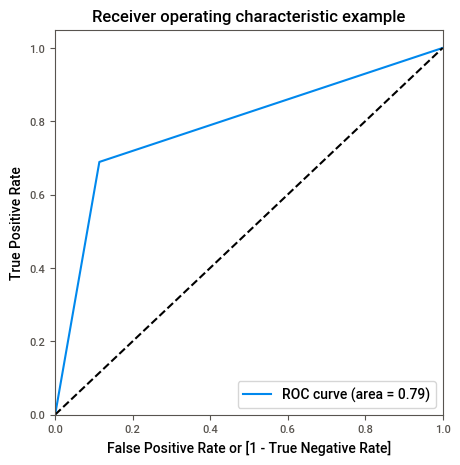

In [101]:
# Visualize
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Predicted)


In [102]:
# Let's create  columns with different probability cut-off's
numbers=[float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]=y_train_pred_final.Converted_prob.map(lambda x:1 if x>i else 0)
y_train_pred_final.head()


,Converted,Converted_prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.237533,0,1,1,1,0,0,0,0,0,0,0
1,1,0.696583,1,1,1,1,1,1,1,1,0,0,0
2,0,0.075876,0,1,0,0,0,0,0,0,0,0,0
3,0,0.128884,0,1,1,0,0,0,0,0,0,0,0
4,0,0.145910,0,1,1,0,0,0,0,0,0,0,0


In [103]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1

    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)


     prob  accuracy     sensi     speci
0.0   0.0  0.371212  1.000000  0.000000
0.1   0.1  0.598646  0.959184  0.385799
0.2   0.2  0.726628  0.921407  0.611638
0.3   0.3  0.794165  0.814155  0.782363
0.4   0.4  0.809800  0.749023  0.845681
0.5   0.5  0.812863  0.689101  0.885927
0.6   0.6  0.791908  0.564047  0.926429
0.7   0.7  0.780464  0.487625  0.953345
0.8   0.8  0.747582  0.364307  0.973853
0.9   0.9  0.715345  0.250977  0.989490


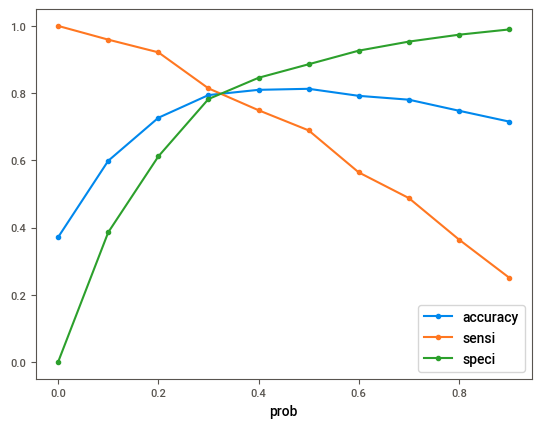

In [104]:
# Let us now plot accuracy, sensitivity  and specificity for various probabilities
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'],marker = "o")
plt.show()


### From the above Plot 0.32 is the optimal cut-off probability

In [105]:
y_train_pred_final['final_predicted']=y_train_pred_final.Converted_prob.map(lambda x: 1 if x>0.32 else 0)
y_train_pred_final.head()


,Converted,Converted_prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.237533,0,1,1,1,0,0,0,0,0,0,0,0
1,1,0.696583,1,1,1,1,1,1,1,1,0,0,0,1
2,0,0.075876,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.128884,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0.145910,0,1,1,0,0,0,0,0,0,0,0,0


In [106]:
# Lets check the final accuracy now
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted))


0.7998065764023211


**11. Precision and Recall**

In [107]:
# Create confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
# Calculate accuracy
print(confusion)


[[3456  445]
 [ 716 1587]]


In [108]:
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [109]:
Precision= float(TP/(TP+FP))
Precision


0.781003937007874

In [110]:
Recall=float(TP/(TP+FN))
Recall


0.6891011723838472

In [111]:
from sklearn.metrics import precision_score,recall_score


In [112]:
precision_score(y_train_pred_final.Converted,y_train_pred_final.Predicted)


0.781003937007874

In [113]:
recall_score(y_train_pred_final.Converted,y_train_pred_final.Predicted)


0.6891011723838472

## Precision_ Recall trade_off

In [114]:
from sklearn.metrics import precision_recall_curve


In [115]:
y_train_pred_final.Converted, y_train_pred_final.Predicted


(0       0
 1       1
 2       0
 3       0
 4       0
        ..
 6199    0
 6200    1
 6201    1
 6202    1
 6203    0
 Name: Converted, Length: 6204, dtype: int64,
 0       0
 1       1
 2       0
 3       0
 4       0
        ..
 6199    0
 6200    0
 6201    0
 6202    1
 6203    0
 Name: Predicted, Length: 6204, dtype: int64)

In [116]:
p,r,thresholds=precision_recall_curve(y_train_pred_final.Converted,y_train_pred_final.Converted_prob)


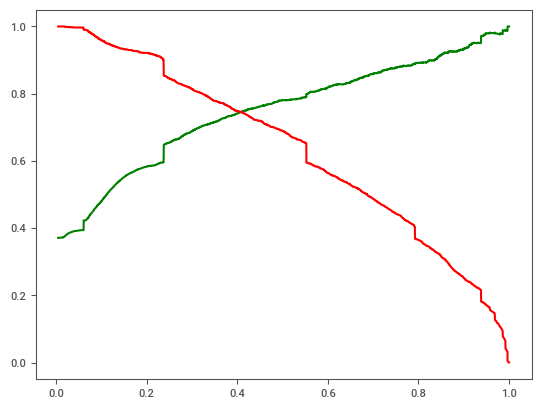

In [117]:
plt.plot(thresholds,p[:-1], "g-")
plt.plot(thresholds,r[:-1], "r-")


## Making Predictions on Test Set

In [118]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]=scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

In [119]:
X_test=X_test[cols]
X_test.head()


,Page Views Per Visit,TotalVisits,Total Time Spent on Website,Last Activity_SMS Sent,Lead Origin_Lead Add Form,Lead Source_Olark Chat,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,What is your current occupation_Working Professional,Do Not Email_Yes,Last Activity_Had a Phone Conversation
8786,0.000000,0.000000,0.000000,0,1,0,0,1,0,0,0
7813,0.333333,0.176471,0.141535,0,0,0,0,0,0,0,0
2405,0.388889,0.411765,0.283070,1,0,0,0,0,0,0,0
7246,0.333333,0.176471,0.103430,0,0,1,1,0,0,0,0
5366,0.222222,0.352941,0.395210,0,0,0,0,0,0,0,0


In [120]:
## Making Predictions on test set
X_test_sm = sm.add_constant(X_test)


In [121]:
y_test_pred = res.predict(X_test_sm)


In [122]:
y_test_pred[:10]


8786    0.748947
7813    0.178653
2405    0.965628
7246    0.310856
5366    0.220949
3924    0.124251
3349    0.126431
916     0.190661
7732    0.135587
1703    0.194966
dtype: float64

In [123]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)


In [124]:
y_pred_1.head()


,0
8786,0.748947
7813,0.178653
2405,0.965628
7246,0.310856
5366,0.220949


In [125]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)


In [126]:
# Removing index for both dataframes to append them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)


In [127]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)


In [128]:
y_pred_final.head()


,Converted,0
0,1,0.748947
1,0,0.178653
2,1,0.965628
3,0,0.310856
4,0,0.220949


In [129]:
# Renaming the column
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})


In [130]:
# Let's see the head of y_pred_final
y_pred_final.head()


,Converted,Converted_Prob
0,1,0.748947
1,0,0.178653
2,1,0.965628
3,0,0.310856
4,0,0.220949


In [131]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.4 else 0)


In [132]:
y_pred_final.head()


,Converted,Converted_Prob,final_predicted
0,1,0.748947,1
1,0,0.178653,0
2,1,0.965628,1
3,0,0.310856,0
4,0,0.220949,0


In [133]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)


0.6558856713050019

In [134]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2


array([[1151,  476],
       [ 439,  593]], dtype=int64)

In [135]:
TP = confusion2[1,1] # true positive
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives


In [136]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)


0.5746124031007752

In [137]:
# Let us calculate specificity
TN / float(TN+FP)


0.7074370006146281

In [138]:
res.params.sort_values(ascending=False)

Lead Origin_Lead Add Form                               3.985567
Total Time Spent on Website                             3.850192
What is your current occupation_Working Professional    2.901561
Last Activity_Had a Phone Conversation                  2.259259
Lead Source_Welingak Website                            2.084406
TotalVisits                                             1.706243
Lead Source_Olark Chat                                  1.482175
Last Activity_SMS Sent                                  1.377043
Page Views Per Visit                                   -0.885033
Do Not Email_Yes                                       -1.388751
Last Activity_Olark Chat Conversation                  -1.566924
const                                                  -2.648428
dtype: float64

**Conclusions**

### Summary

The company has to set sales teams to focus on the below features to convert maximum leads.

- Lead Origin_Lead Add Form   
- Total Time Spent on Website
- What is your current occupation_Working Professional
- Last Activity_Had a Phone Conversation
- Lead Source_Welingak Website
- TotalVisits
- Lead Source_Olark Chat
- Last Activity_SMS Sent




### ***END***